# Sales Forecasting: In-Depth Example

In this example we will model a simulated dataset of daily item sales. Because the sales are integer valued, we'll use a Poisson DGLM:

$$y_t \sim Pois(\mu_t)$$
$$\log(\mu_t) = \lambda_t = F_t^{'} \theta_t$$


Where $\theta_t$ is the state vector, $\mu_t$ is the Poisson mean, and $\lambda_t$ is called the linear predictor.

We're going to define a dynamic model with the following components in the state vector:

- **Trend:** 1 intercept term
- **Regression:** 2 regression terms for Price and a 0-1 indicator for any sales or promotions.
- **Holidays:** We use 10 standard holidays. These are actually just more regression terms, with a 0-1 indicator for each holiday.
- **Seasonality:** A seasonal component with period 7 for the day-of-the-week. The seasonality is defined in terms of harmonic components - we'll use the first 3, which means there are 6 coefficients. We will demonstrate how to translate the coefficients into 7 interpretable values, one for each day of the week.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar
from pybats.analysis import analysis
from pybats.point_forecast import median
from pybats.plot import plot_data_forecast, ax_style, plot_coef
from pybats.shared import load_sales_example2

### Load in the data

In [2]:
data = load_sales_example2()
data.head()

,Sales,Price,Promotion
Date,,,
2014-06-01,15.0,1.11,0.0
2014-06-02,13.0,2.19,0.0
2014-06-03,6.0,0.23,0.0
2014-06-04,2.0,-0.05,1.0
2014-06-05,6.0,-0.14,0.0


The simulated dataset contains daily sales of an item from June 1, 2014 to June 1, 2018. 

- The Price column represents percent change in price from the moving average, so it's centered at 0.
- Promotion is a 0-1 indicator for a specific sale or promotion on the item.

### Run the analysis

The PyBATS analysis function provides an easy wrapper that will:

- Define a model prior
- Sequentially update the model (forward filter) and forecast k steps ahead
- Return the final model, forecast samples, and potentially the stored model coefficients

We know what terms we want in our model, and we'll need to define them using the analysis function. When we pass in the covariates (Price and Promotion) and list of holidays, those terms are automatically added to the model. We will manually say that we want a seasonal component with a period of 7. An intercept (1 trend term) is the default, so we don't need to pass in any arguments for that.

We also have to set a few parameters that specify what dates we want to forecast, what forecast horizon we're considering, and how many data points to use for setting a prior.

In [3]:
prior_length = 21   # Number of days of data used to set prior
k = 7               # Forecast horizon
rho = 0.5           # Random effect discount factor to increase variance of forecast distribution
forecast_samps = 2000  # Number of forecast samples to draw
forecast_start = pd.to_datetime('2017-01-01') # Date to start forecasting
forecast_end = pd.to_datetime('2018-05-24')   # Date to stop forecasting

In [4]:
mod, samples, model_coef = analysis(data.Sales.values, data[['Price', 'Promotion']].values,
                        k, forecast_start, forecast_end, nsamps=forecast_samps,
                        family='poisson',
                        seasPeriods=[7], seasHarmComponents=[[1,2,3]],
                        prior_length=prior_length, dates=data.index, holidays=USFederalHolidayCalendar.rules,
                        rho=rho,
                        ret = ['model', 'forecast', 'model_coef'])

beginning forecasting


We specified the desired output with the argument 'ret', for return. The outputs are:

- **Model**: The model is of class _dglm_, and has been sequentially updated through to the date *forecast_end*.
- **Forecast Samples:** Each day in the range *forecast_start* to *forecast_end*, the model forecasts _k_ steps ahead, drawing samples from the forecast distribution. The output samples have shape (*forecast_samps* \* *forecast_length* \* *k*).
- **Model Coefficients:** Not part of the default output from the analysis function, but we're interested how the day-of-week effect changes over time, so we've saved the complete history of the state vector. This contains the posterior means and variances.

### Plot the forecast results

Let's start by looking at the 1-step ahead forecasts over the full forecasting period:

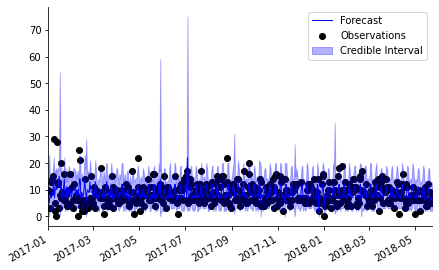

In [7]:
data_1step = data.loc[forecast_start:forecast_end]
samples_1step = samples[:,:,0]
fig, ax = plt.subplots(1,1)
ax = plot_data_forecast(fig, ax,
                        data_1step.Sales,
                        median(samples_1step),
                        samples_1step,
                        data_1step.index,
                        credible_interval=95)

We're plotting the median forecasts along with the $75\%$ credible intervals. One very clear pattern is the weekly effect, with a weekly spike in our forecasts. There's also a very noticable holiday effect - sales are unpredictable on holidays, and our credible intervals become very large.

You're probably wondering: How accurate are those point forecasts?

In [8]:
from pybats.loss_functions import MAD, ZAPE
print(MAD(data_1step.Sales, median(samples_1step)))
print(ZAPE(data_1step.Sales, median(samples_1step)))

2.692534381139489
49.01564662463881


The first loss function is the Mean Absolute Deviation (MAD). Note that we're using the median for our point forecast - the median is the optimal forecast for minimizing the MAD, just as the mean is optimal for minimizing the Mean Square Error (MSE).

The second number is the Zero-Adjusted Absolute Percent Error (ZAPE). This is equivalent to the Mean Absolute Percent Error (MAPE), but is still defined even when the sales are 0. On days when sales are 0, then the ZAPE loss is equal to the forecast. Interpreting this as a percent error metric, we're off by a significant margin - but not bad for noisy sales data either! The median is not the optimal forecast to minimize ZAPE, but it's a simple and easy point forecast to obtain.

Okay, now let's zoom in to just the final 60 days of forecasting, to a more detailed picture of our online, sequential forecasts:

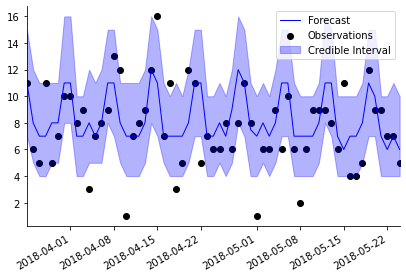

In [9]:
data_1step = data.loc[forecast_end-pd.DateOffset(60):forecast_end]
samples_1step = samples[:,-61:,0]
fig, ax = plt.subplots(1,1)
ax = plot_data_forecast(fig, ax,
                        data_1step.Sales,
                        median(samples_1step),
                        samples_1step,
                        data_1step.index,
                        credible_interval=75)

These forecasts look pretty good! Our $75\%$ credible intervals capture the true sales most of the time, as it should.  The weekly pattern is much more clearly visible here.

What if we want to monitor the day-of-week effects? It looks like they're changing over time - what days are becoming more or less popular? Well, that's why we saved the model coefficients, so we can answer exactly that question!

### Plotting the day-of-week seasonality

We start by taking the posterior coefficents and only looking at the 6 seasonal coefficients, using the 'mod.iseas' property to get the indices for the seasonal components.

Then, we transform these harmonic seasonal components into interpretable coefficients for the 7 days of the week. For more details on this process, look at _Bayesian Forecasting and Dynamic Models_ by Harrison and West, Chapter 8.

In [10]:
harm_post_mean = model_coef['m'][:,mod.iseas[0]]
dow_post_mean = mod.L[0] @ harm_post_mean.T

Next, we'll align these 7 components with the days of the week, and plot the posterior mean of the coefficients over time. Unfortunately, the structure of the seasonal components means that even after the transformation, the days are rotated. The 'current' day will always appear first in each row in the matrix, so we're going to pluck only that day.

In [11]:
def order_dow(seas_eff, date):
    day = date.dayofweek
    out = np.zeros(7)
    out[day] = seas_eff[0]
    return(out)

In [12]:
dow_post_mean_plot = pd.DataFrame([order_dow(seas_eff, date) for seas_eff, date in zip(dow_post_mean.T, data.loc[:forecast_end].index)])
dow_post_mean_plot = dow_post_mean_plot.replace(to_replace=0, method='ffill')

In [13]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

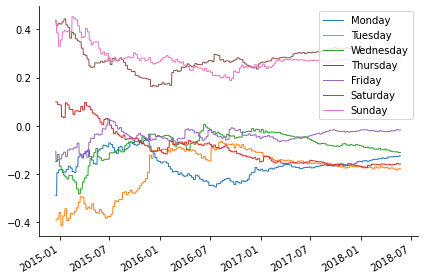

In [14]:
start_day = 200    # Only starting to plot after model has learned the day-of-week effect
fig, ax = plt.subplots(1,1)
ax = plot_coef(fig, ax, dow_post_mean_plot.iloc[start_day:], dates=data.iloc[start_day:].loc[:forecast_end].index, legend=days)

Okay, now this is interesting! We have a few clear takeaways:

- Saturday and Sunday have the highest sales
- Monday through Thursday all have very similar sales, with coefficients between -0.1 to -0.2.

These effects in the state space are additive on the log scale. Remember the Poisson DGLM has a log-link function:

$$\log(\mu_t) = \lambda_t$$
$$\lambda_t = F_t^{'} \theta_t$$

If we want to interpret these effects in terms of actual sales, we need to recognize that they are additive and on the log scale in the state space. In terms of the prior mean, the effect is multiplicative. First, we can decompose the linear predictor into seasonal and other terms:

$$F_t^{'} \theta_t = F_{seas, t}^{'} \theta_{seas, t} + F_{other, t}^{'} \theta_{other, t}$$

Then think in terms of the conjugate prior:

$$\mu_t = e^{F_{seas, t}^{'} \theta_{seas, t}} * e^{F_{other, t}^{'} \theta_{other, t}}$$

The regression vector F_seas is just a 0-1 indicator to pluck out the correct day's seasonal effect. So to interpret each day's _multiplicative_ effect on sales, we take the exponent of the graph above:

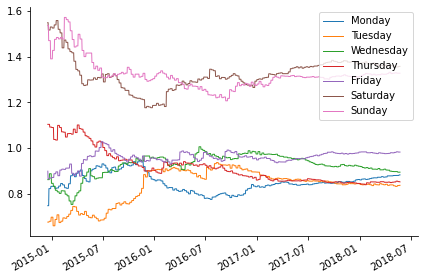

In [15]:
fig, ax = plt.subplots(1,1)
ax = plot_coef(fig, ax, np.exp(dow_post_mean_plot)[start_day:], dates=data.iloc[start_day:].loc[:forecast_end].index, legend=days)

Perfect, this is very clear! A multiplicative seasonal effect of 1 has no effect on Sales. Anything larger than 1 boosts sales, and smaller than 1 reduces them. Looking at the end of the time period, we can say:

- Saturday and Sunday have around 30-40% higher sales than the average day.
- Monday-Thursday all have between 10-20% lower sales than the average day.
- Friday lands in the middle, with approximately average sales.

The long term trends look fairly stable, which is natural - shopping habits change slowly over time. Part of that also comes from our model definition. The discount factor on the seasonality component is very close to 1, so we discount historical information slowly. If we believed that these day-of-week effects changed more rapidly over time, we could re-run the analysis with a lower discount factor, using the parameter _delseas_ as an argument to the analysis function.

### Conclusions

In this example we've used the PyBATS package to complete an analysis of simulated sales data. We:

- Used the 'analysis' function to define a Poisson DGLM with the first 21 days of data. It then performed online model updating and forecasting, 1-7 days ahead.
- Analyzed the 1-day ahead forecasts, and calculated two error metrics on our point forecasts.
- Plotted the forecasts, saw the added uncertainty caused by holidays, and the very strong day-of-week effects.
- Deep-dived into those day-of-week effects, plotting their evolution over time

There's plenty more that we could have explored here as well:

- Forecasts with a longer horizon. How accurate are our 7-day ahead forecasts, and are they also well calibrated?
- Other state vector components, such as the trend, regression, and holiday terms. They are all saved in the _model_coef_ output. To interpret them, we need to transform from the log scale into the space of the conjugate prior, just as we did with the seasonal effects.
- Forecast _totals_ over the next week or month. This type of forecasting requires drawing joint samples over 1:k days into the future, and then taking a sum over each sample from the forecast distribution. This is known as _path forecasting_, and can be accomplished with the method *mod.path_forecast*.